In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [58]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand((batch_size, 1,  N_agents * in_dim)).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i], max=L[i])
    return x

In [59]:
N_Agents = 3
in_dim = 1
batch_size = 256
n_samples = 1024 * 2
timesteps = 100
lam = 0.5
control_energy_reg = 1e-6 ### regularization on maximum control energy
k_max = 256
u_max = 100 # does not do anything currently
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)

In [61]:
import Ergodic_Loss
import GRU
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\GRU.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(GRU)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max,control_energy_reg = control_energy_reg,verbose = False, device = device, density = 'custom', pdf = custom_pdf, max_pdf = 5 / 3, num_samples = 100000)
model = GRU.GRU(in_dim = in_dim, N_Agents = N_Agents ,hidden = 256, n_timesteps = timesteps, depth = 3)
model.to_device()
model.init_hidden(batch_size)


In [62]:
import time
start_time = time.time()
model.init_hidden(batch_size = batch_size)
control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
loss.backward()
time_ellapsed = time.time() - start_time 
print(time_ellapsed, f"time of one iteration, expected total time {time_ellapsed * (n_samples / batch_size)} per epoch")

2.9827332496643066 time of one iteration, expected total time 23.861865997314453 per epoch


Epoch [1/100], Loss: 0.659939
Epoch [2/100], Loss: 0.639640
Epoch [3/100], Loss: 0.638753
Epoch [4/100], Loss: 0.638068
Epoch [5/100], Loss: 0.637361
Epoch [6/100], Loss: 0.636545
Epoch [7/100], Loss: 0.635828
Epoch [8/100], Loss: 0.634822
Epoch [9/100], Loss: 0.631846
Epoch [10/100], Loss: 0.629086
Epoch [11/100], Loss: 0.628153
Epoch [12/100], Loss: 0.627887
Epoch [13/100], Loss: 0.627849
Epoch [14/100], Loss: 0.627799
Epoch [15/100], Loss: 0.627815
Epoch [16/100], Loss: 0.631370
Epoch [17/100], Loss: 0.630098
Epoch [18/100], Loss: 0.628065
Epoch [19/100], Loss: 0.627871
Epoch [20/100], Loss: 0.627713
Epoch [21/100], Loss: 0.628527
Epoch [22/100], Loss: 0.636764
Epoch [23/100], Loss: 0.637910
Epoch [24/100], Loss: 0.635621
Epoch [25/100], Loss: 0.639612
Epoch [26/100], Loss: 0.638891
Epoch [27/100], Loss: 0.638142
Epoch [28/100], Loss: 0.637313
Epoch [29/100], Loss: 0.635901
Epoch [30/100], Loss: 0.632520
Epoch [31/100], Loss: 0.628839
Epoch [32/100], Loss: 0.628132
Epoch [33/100], L

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [100/100], Loss: 0.627674


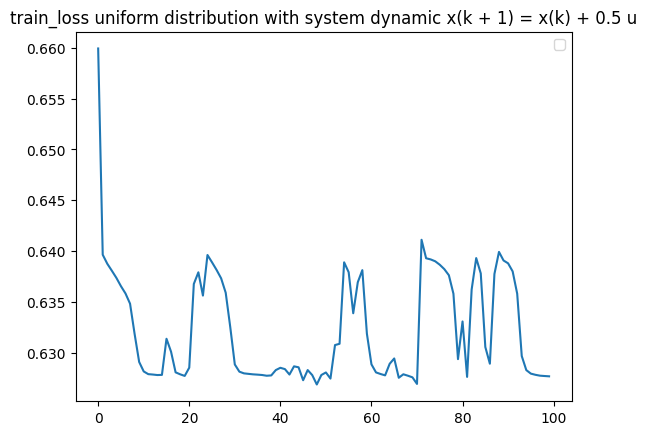

Training Complete!


In [63]:
epochs = 100  # Number of epochs to train
optimizer = optim.AdamW(model.parameters(), lr=0.001)
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
model.to_device()
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        control , outputs = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / n_samples
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

3
torch.Size([100, 1, 1, 3])


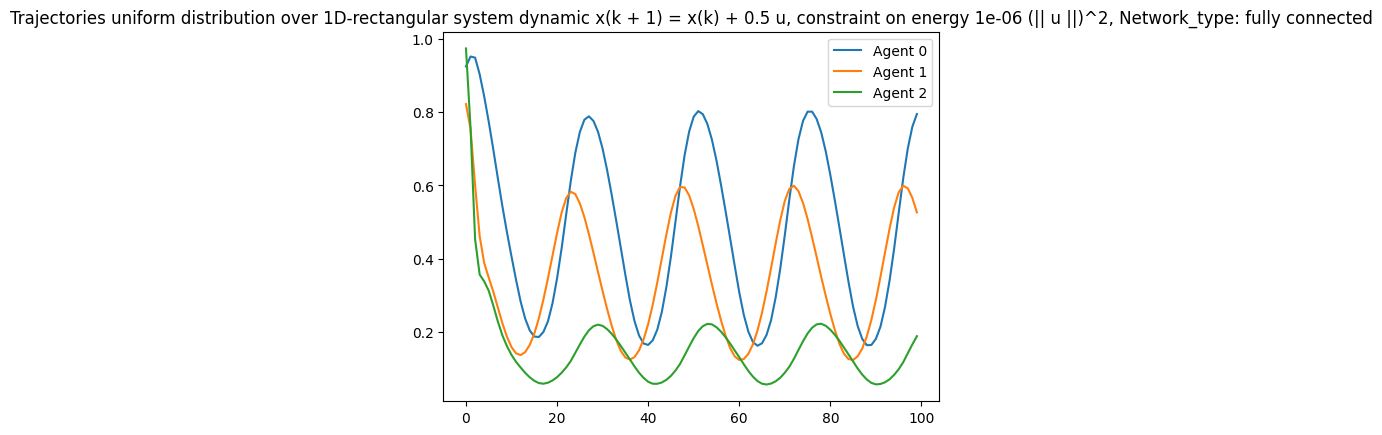

In [72]:
#plot trajectory
model.eval()
print(model.N_Agents)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
#print(inital_state)
model.to_device()
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
print(outs.shape)
#print(outs)
#TODO wont work for more Dimensions implement as in forward loop! 
for i in range(N_Agents):
    plt.plot(outs[:,:,:,i].squeeze().detach(), label = f'Agent {i}')
plt.title(f'Trajectories uniform distribution over 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2, Network_type: fully connected')
plt.legend()
plt.show()


In [74]:
import Ergodic_Loss
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
import importlib
importlib.reload(Ergodic_Loss)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = 64,control_energy_reg = control_energy_reg, device = torch.device('cpu'), density = 'custom', pdf = custom_pdf, max_pdf = 5 / 3, num_samples = 100000)
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
criterion.verbose = True
criterion(x = outs, u = control)

model tensor([[ 3.3333e-01,  9.0455e-02,  2.9140e-02,  4.2292e-02,  4.7585e-02,
         -2.9200e-02, -4.9336e-02,  3.5326e-03, -1.4301e-02,  1.1057e-03,
          8.2917e-03, -6.4363e-03, -4.4933e-03,  7.4255e-05,  8.5857e-03,
         -3.2572e-02, -7.6857e-03, -1.7153e-02, -3.4749e-02,  4.0772e-03,
          1.2233e-02, -1.7722e-02,  7.7886e-03,  3.4669e-02,  2.8945e-02,
         -9.4490e-03, -1.4233e-03, -6.2338e-03,  2.5885e-03,  6.7024e-03,
         -8.9863e-03, -2.7504e-03, -2.5625e-03,  1.3644e-02, -2.2843e-02,
         -6.9509e-03,  8.9666e-03, -9.9285e-03,  2.0634e-03, -4.3294e-03,
          2.8354e-03, -1.6942e-02,  5.3327e-03, -1.2890e-02, -2.8509e-02,
          2.5467e-02,  2.7463e-02,  5.0000e-03,  4.3435e-02,  1.1105e-03,
          2.0241e-02, -1.0821e-03,  2.8182e-03,  2.2234e-03, -1.4882e-03,
          1.4910e-02,  2.9914e-02,  1.3870e-02,  3.2166e-04, -4.1304e-03,
         -2.6056e-02, -2.0012e-02,  1.6294e-02, -4.1345e-02]],
       grad_fn=<CopySlices>) target tensor(

c:\Users\JP\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:939: UserWarning: Using a target size (torch.Size([1, 1, 64])) that is different to the input size (torch.Size([1, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


tensor(0.0569, grad_fn=<AddBackward0>)

In [73]:
criterion(x = outs, u = control)

model tensor([[ 3.3333e-01,  7.5457e-02,  4.4116e-02,  4.9614e-02,  6.5654e-02,
         -1.2818e-02, -4.6917e-02,  4.3332e-03, -1.3788e-02, -5.6793e-03,
         -1.0222e-02, -1.4526e-03, -3.3458e-03,  1.3540e-02,  2.0796e-02,
         -2.1166e-02, -5.2021e-03, -1.2492e-02, -1.5970e-02, -8.0033e-03,
          1.0282e-03, -3.6080e-03, -2.3166e-03,  3.6162e-02,  1.4113e-03,
         -6.4585e-03, -2.5169e-02,  2.2434e-02, -4.3289e-03, -5.8389e-03,
          6.8935e-03, -1.6962e-03,  1.3858e-02,  2.3910e-02, -2.0755e-02,
         -7.4097e-03,  1.3740e-02, -6.2289e-03,  1.5533e-02, -3.1080e-03,
          2.8659e-03, -1.9055e-02, -1.3890e-02, -2.3179e-02, -1.7877e-02,
          2.4352e-03,  1.4059e-03,  6.9864e-03,  3.1677e-02,  1.4818e-02,
          2.9207e-02,  6.1176e-03,  7.2444e-05,  1.7660e-03,  1.9522e-02,
          2.2708e-02,  1.9858e-02,  3.2906e-02, -1.4053e-02, -2.6629e-02,
         -4.9299e-03,  6.2070e-03, -2.0586e-02, -1.6682e-03]],
       grad_fn=<CopySlices>) target tensor(

tensor(0.0565, grad_fn=<AddBackward0>)